In [1]:
import matplotlib.pyplot as plt
from scope_utils import set_scope, get_waveform, get_trace_data, TraceData
from utils_dBm import dBm_to_Vpp, Vpp_to_dBm, Vpp_to_Vrms, Vrms_to_watt
import h5py
import numpy as np
import pyvisa

from windfreak import SynthHD
import time
import tqdm
import csv
from typing import List, Tuple, Sequence
import datetime
from ds1054z import DS1054Z

In [2]:
resource_name_windfreak = "COM4"
resource_name_oscilloscope = "USB0::0x1AB1::0x04B1::DS4A183300765::INSTR"

rm = pyvisa.ResourceManager()

scope: pyvisa.resources.USBInstrument = rm.open_resource("USB0::0x1AB1::0x04B1::DS4A183300765::INSTR", read_termination = "\n")
synthd = SynthHD(resource_name_windfreak)
synthd.init()


## Initialize scope settings

In [3]:
def select_scale(scale: float) -> float:
    scale_steps = np.ravel([np.array([5,2,1]) * 10**x for x in np.linspace(1,-3,5)])[2:]
    if scale < 1e-3:
        scale_select = 1e-3
    else:
        for ids,s in enumerate(scale_steps):
            if scale >= s:
                scale_select = scale_steps[ids-1]
                break
    return scale_select

In [4]:
def get_trace(
    scope: pyvisa.resources.USBInstrument, channels: Sequence[int]
) -> TraceData:
    scope.write(":SINGLE")
    while True:
        if scope.query(":TRIG:STAT?") == "STOP":
            break
        time.sleep(0.05)
    trace = get_trace_data(scope, channels)
    scope.write(":CLEAR")
    return trace

Signal generator input  is 0 dB

In [19]:
# there are 8 divisions
ndiv = 8

synthd.init()

rf_out = 0         # 0 for RFout A, 1 for RFout B
rf_fre = 50e6     # rf ouput frequency, unit Hz
amplitude_int = -10    #rf output power, unit dBm

synthd[rf_out].frequency = rf_fre
synthd[rf_out].power = amplitude_int
synthd[rf_out].enable = True



In [20]:
time_div = 1./ rf_fre
t_offset = 0
offset = 0

channel = 1
scope.write(f":CHAN{channel}:DISP 1")

scale_ch1 = dBm_to_Vpp(amplitude_int)/ndiv*2
scale_ch1 = select_scale(scale_ch1)

set_scope(scope, channel, scale_ch1, offset, time_div, t_offset)

scope.write(":START")
scope.write(":ACQ:MDEP 6000")
scope.write(":CLEAR")

8

In [21]:
y = get_trace(scope, [channel])

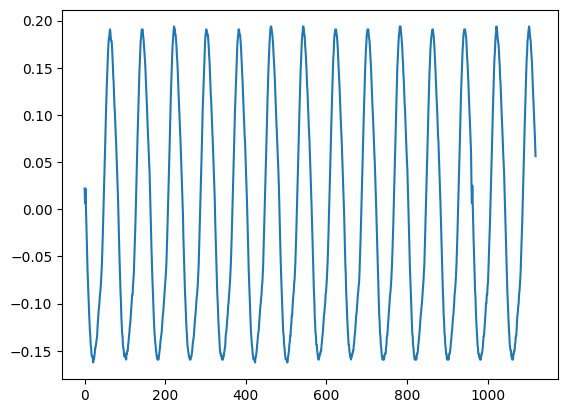

In [22]:
plt.plot(y.transmission)

In [8]:

scan_data: List[Tuple[float, TraceData]] = []
for frequency in tqdm.tqdm(np.linspace(1.55e6,1.65e6,101)):
    trace = get_trace(scope, [channel_transmission, channel_reflection])
    ptp_transmission = trace.transmission.ptp()
    ptp_reflection = trace.reflection.ptp()
    scope.write(f":CHAN{channel_transmission}:SCAL {ptp_transmission/ndiv * 1.2}")
    scope.write(f":CHAN{channel_reflection}:SCAL {ptp_reflection/ndiv * 1.2}")
    
    trace = get_trace(scope, [channel_transmission,channel_reflection])
    scope.write(f":CHAN{channel_reflection}:SCAL {scale_ch1}")
    scan_data.append((frequency, trace))

  0%|          | 0/101 [00:00<?, ?it/s]


NameError: name 'channel_transmission' is not defined

In [ ]:
synthd[rf_out].enable = False